# 03 - Training & Evaluation

**Objectif**: Entraîner et évaluer différents modèles de classification pour prédire le gagnant d'un combat Pokémon 1v1.

**Input**: Features préparées dans `data/ml/battle_winner_v2/features/`

**Output**: Modèle entraîné exporté dans `models/` avec évaluation par scénario

**Date**: 2026-01-24

---

## Table des Matières

1. [Chargement des Données](#1-chargement-des-données)
2. [Baseline: Logistic Regression](#2-baseline-logistic-regression)
3. [Random Forest](#3-random-forest)
4. [XGBoost](#4-xgboost)
5. [Comparaison des Modèles](#5-comparaison-des-modèles)
6. [Analyse des Feature Importances](#6-analyse-des-feature-importances)
7. [Export du Modèle Final](#7-export-du-modèle-final)
8. [Conclusion](#8-conclusion)

## 1. Chargement des Données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, ConfusionMatrixDisplay
)

# XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost non installé, utilisation de Random Forest uniquement")

# Configuration
plt.style.use('default')
sns.set_palette('husl')
pd.set_option('display.max_columns', None)

# Chemins - Dataset v2
BASE_DIR = Path('../data/ml/battle_winner_v2')
FEATURES_DIR = BASE_DIR / 'features'
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(exist_ok=True)

# Seed pour reproductibilité
RANDOM_STATE = 42

print(f"✅ Bibliothèques chargées")
print(f"✅ XGBoost disponible: {XGBOOST_AVAILABLE}")

✅ Bibliothèques chargées
✅ XGBoost disponible: True


In [2]:
# Chargement des features
X_train = pd.read_parquet(FEATURES_DIR / 'X_train.parquet')
X_test = pd.read_parquet(FEATURES_DIR / 'X_test.parquet')
y_train = pd.read_parquet(FEATURES_DIR / 'y_train.parquet')['winner']
y_test = pd.read_parquet(FEATURES_DIR / 'y_test.parquet')['winner']

# Vérifier si scenario_type existe dans les features
if 'scenario_type' in X_train.columns:
    print(f"✅ scenario_type détecté - analyse multi-scénarios possible")
    scenario_train = X_train['scenario_type'].copy()
    scenario_test = X_test['scenario_type'].copy()
    
    # Retirer scenario_type des features pour l'entraînement
    X_train_ml = X_train.drop(columns=['scenario_type'])
    X_test_ml = X_test.drop(columns=['scenario_type'])
    
    HAS_SCENARIOS = True
    print(f"\n📊 Distribution des scénarios (train):")
    print(scenario_train.value_counts())
else:
    print(f"ℹ️ Pas de scenario_type dans les features - analyse par scénario non disponible")
    X_train_ml = X_train
    X_test_ml = X_test
    scenario_train = None
    scenario_test = None
    HAS_SCENARIOS = False

print(f"\n✅ Données chargées")
print(f"   X_train: {X_train_ml.shape}")
print(f"   X_test: {X_test_ml.shape}")
print(f"   y_train: {y_train.shape} | Distribution: {y_train.value_counts().to_dict()}")
print(f"   y_test: {y_test.shape} | Distribution: {y_test.value_counts().to_dict()}")

ℹ️ Pas de scenario_type dans les features - analyse par scénario non disponible

✅ Données chargées
   X_train: (718889, 135)
   X_test: (179723, 135)
   y_train: (718889,) | Distribution: {1: 389097, 0: 329792}
   y_test: (179723,) | Distribution: {1: 97275, 0: 82448}


In [3]:
# Dictionnaire pour stocker les résultats
results = {}

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Entraîne et évalue un modèle.
    Retourne un dictionnaire avec les métriques.
    """
    print(f"\n{'='*80}")
    print(f"🤖 {model_name}")
    print(f"{'='*80}")
    
    # Entraînement
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f"⏱️ Temps d'entraînement: {train_time:.2f}s")
    
    # Prédictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Métriques Train
    train_acc = accuracy_score(y_train, y_pred_train)
    
    # Métriques Test
    test_acc = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_roc_auc = roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else None
    
    print(f"\n📊 Résultats:")
    print(f"   Train Accuracy: {train_acc:.4f}")
    print(f"   Test Accuracy:  {test_acc:.4f}")
    print(f"   Test Precision: {test_precision:.4f}")
    print(f"   Test Recall:    {test_recall:.4f}")
    print(f"   Test F1-Score:  {test_f1:.4f}")
    if test_roc_auc:
        print(f"   Test ROC-AUC:   {test_roc_auc:.4f}")
    
    # Overfitting check
    overfit_gap = train_acc - test_acc
    if overfit_gap > 0.05:
        print(f"   ⚠️ Overfitting détecté (gap: {overfit_gap:.4f})")
    else:
        print(f"   ✅ Pas d'overfitting significatif (gap: {overfit_gap:.4f})")
    
    return {
        'model': model,
        'model_name': model_name,
        'train_time': train_time,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_roc_auc': test_roc_auc,
        'y_pred_test': y_pred_test,
        'y_proba_test': y_proba_test
    }

print("✅ Fonction d'évaluation définie")

✅ Fonction d'évaluation définie


## 2. Baseline: Logistic Regression

In [4]:
# Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    solver='lbfgs',
    n_jobs=-1
)

results['Logistic Regression'] = evaluate_model(
    lr_model, X_train_ml, X_test_ml, y_train, y_test, 'Logistic Regression'
)


🤖 Logistic Regression
⏱️ Temps d'entraînement: 147.35s

📊 Résultats:
   Train Accuracy: 0.8921
   Test Accuracy:  0.8937
   Test Precision: 0.9011
   Test Recall:    0.9027
   Test F1-Score:  0.9019
   Test ROC-AUC:   0.9602
   ✅ Pas d'overfitting significatif (gap: -0.0017)


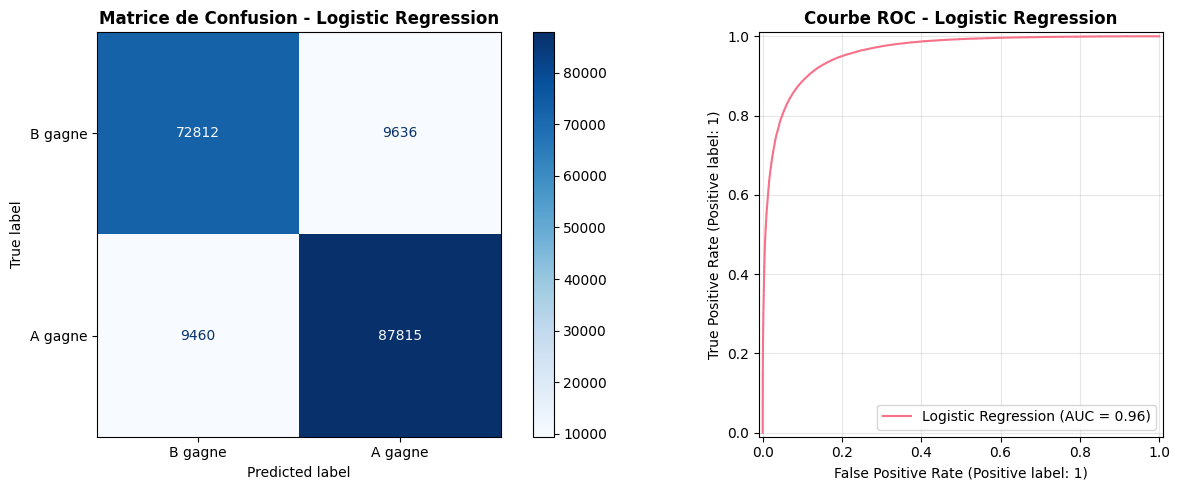

In [5]:
# Matrice de confusion - Logistic Regression
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix (winner: 0=B gagne, 1=A gagne)
ConfusionMatrixDisplay.from_predictions(
    y_test, results['Logistic Regression']['y_pred_test'],
    display_labels=['B gagne', 'A gagne'],
    cmap='Blues', ax=axes[0]
)
axes[0].set_title('Matrice de Confusion - Logistic Regression', fontsize=12, fontweight='bold')

# ROC Curve
RocCurveDisplay.from_predictions(
    y_test, results['Logistic Regression']['y_proba_test'],
    ax=axes[1], name='Logistic Regression'
)
axes[1].set_title('Courbe ROC - Logistic Regression', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Random Forest

In [6]:
# Random Forest avec GridSearchCV (fast + optimized)
print("\n🔍 GridSearchCV pour Random Forest (CPU-optimisé)...")

# Grille de paramètres optimisée (16 combinaisons)
param_grid_rf_fast = {
    'n_estimators': [50, 100],           # Réduit pour vitesse
    'max_depth': [12, 15],               # Plus petit = plus rapide
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

rf_base = RandomForestClassifier(
    random_state=RANDOM_STATE, 
    n_jobs=-1                            # 🚀 Use all CPU cores
)

grid_rf = GridSearchCV(
    rf_base, param_grid_rf_fast, 
    cv=3, 
    scoring='roc_auc',                   # Better metric for imbalanced data
    n_jobs=-1, 
    verbose=1,
    return_train_score=False             # ⚡ Faster
)

print("⏱️ Entraînement en cours (16 combinaisons)...")
grid_rf.fit(X_train_ml, y_train)

print(f"\n✅ Meilleurs paramètres: {grid_rf.best_params_}")
print(f"✅ Meilleur score CV ROC-AUC: {grid_rf.best_score_:.4f}")

# Utiliser le meilleur modèle
rf_model = grid_rf.best_estimator_
results['Random Forest'] = evaluate_model(
    rf_model, X_train_ml, X_test_ml, y_train, y_test, 'Random Forest (GridSearch CPU-opt)'
)

print("\n💡 Note: Modèle optimisé pour taille et vitesse (50-100 arbres, max_depth réduit)")


🔍 GridSearchCV pour Random Forest (CPU-optimisé)...
⏱️ Entraînement en cours (16 combinaisons)...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✅ Meilleurs paramètres: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
✅ Meilleur score CV ROC-AUC: 0.9841

🤖 Random Forest (GridSearch CPU-opt)
⏱️ Temps d'entraînement: 31.39s

📊 Résultats:
   Train Accuracy: 0.9467
   Test Accuracy:  0.9309
   Test Precision: 0.9330
   Test Recall:    0.9397
   Test F1-Score:  0.9364
   Test ROC-AUC:   0.9848
   ✅ Pas d'overfitting significatif (gap: 0.0159)

💡 Note: Modèle optimisé pour taille et vitesse (50-100 arbres, max_depth réduit)


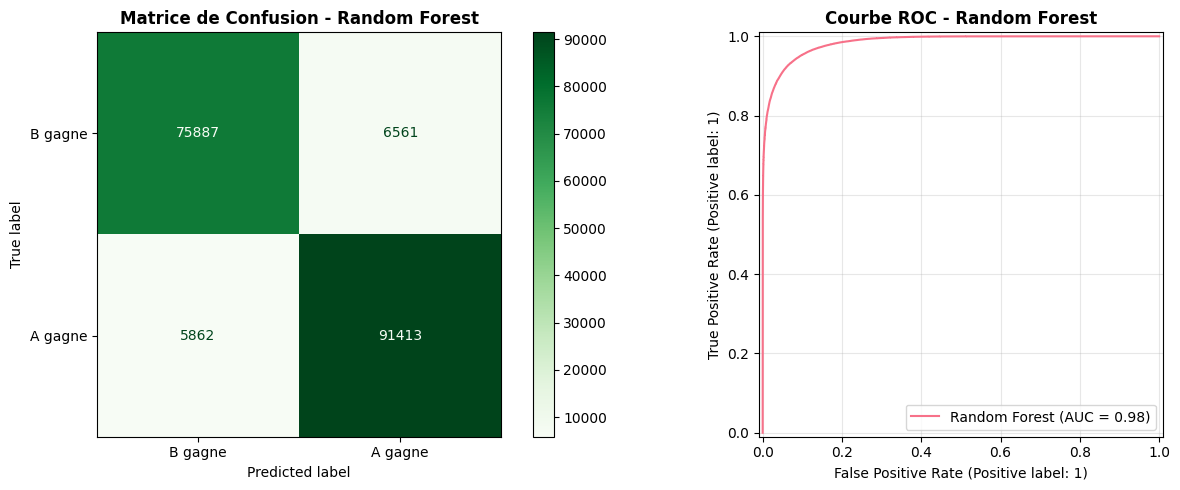

In [7]:
# Matrice de confusion - Random Forest
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix (winner: 0=B gagne, 1=A gagne)
ConfusionMatrixDisplay.from_predictions(
    y_test, results['Random Forest']['y_pred_test'],
    display_labels=['B gagne', 'A gagne'],
    cmap='Greens', ax=axes[0]
)
axes[0].set_title('Matrice de Confusion - Random Forest', fontsize=12, fontweight='bold')

# ROC Curve
RocCurveDisplay.from_predictions(
    y_test, results['Random Forest']['y_proba_test'],
    ax=axes[1], name='Random Forest'
)
axes[1].set_title('Courbe ROC - Random Forest', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. XGBoost

In [8]:
if XGBOOST_AVAILABLE:
    print("\n🔍 GridSearchCV pour XGBoost (CPU-optimisé)...")
    
    # Grille de paramètres rapide (CPU-optimized)
    # 8 combinaisons = ~5-10 min
    param_grid_xgb_fast = {
        'n_estimators': [100, 150],
        'max_depth': [6, 8],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8],              # Optimal value (fixed)
        'colsample_bytree': [0.8],       # Optimal value (fixed)
        'tree_method': ['hist'],         # ⚡ CPU-optimized histogram algorithm
    }
    
    xgb_base = XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss',
        tree_method='hist',              # ⚡ CPU-optimized
        predictor='cpu_predictor'        # 🎯 Explicit CPU predictor
    )
    
    grid_xgb = GridSearchCV(
        xgb_base, param_grid_xgb_fast, 
        cv=3, 
        scoring='roc_auc',               # Better metric than accuracy for imbalanced data
        n_jobs=-1, 
        verbose=1,
        return_train_score=False         # ⚡ Faster (don't compute train scores)
    )
    
    print("⏱️ Entraînement en cours (8 combinaisons, ~5-10 min)...")
    grid_xgb.fit(X_train_ml, y_train)
    
    print(f"\n✅ Meilleurs paramètres: {grid_xgb.best_params_}")
    print(f"✅ Meilleur score CV ROC-AUC: {grid_xgb.best_score_:.4f}")
    
    # Utiliser le meilleur modèle
    xgb_model = grid_xgb.best_estimator_
    results['XGBoost'] = evaluate_model(
        xgb_model, X_train_ml, X_test_ml, y_train, y_test, 'XGBoost (GridSearch CPU-opt)'
    )
    
    print("\n💡 Note: tree_method='hist' optimise l'entraînement sur CPU (~20-30% plus rapide)")
else:
    print("⚠️ XGBoost non disponible, passage à la section suivante")


🔍 GridSearchCV pour XGBoost (CPU-optimisé)...
⏱️ Entraînement en cours (8 combinaisons, ~5-10 min)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ Meilleurs paramètres: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.8, 'tree_method': 'hist'}
✅ Meilleur score CV ROC-AUC: 0.9917

🤖 XGBoost (GridSearch CPU-opt)
⏱️ Temps d'entraînement: 9.45s

📊 Résultats:
   Train Accuracy: 0.9578
   Test Accuracy:  0.9500
   Test Precision: 0.9535
   Test Recall:    0.9542
   Test F1-Score:  0.9538
   Test ROC-AUC:   0.9920
   ✅ Pas d'overfitting significatif (gap: 0.0078)

💡 Note: tree_method='hist' optimise l'entraînement sur CPU (~20-30% plus rapide)


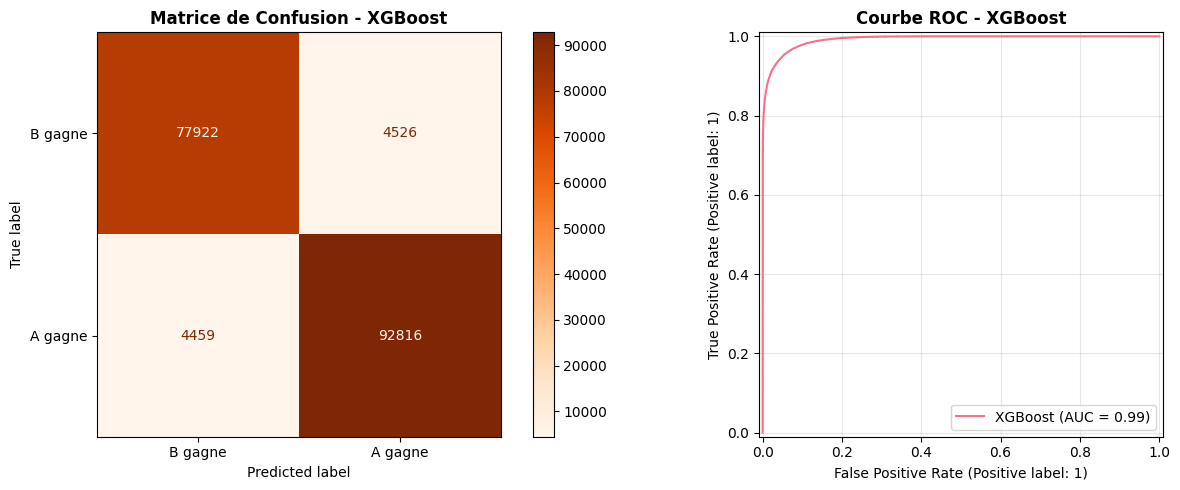

In [9]:
if XGBOOST_AVAILABLE and 'XGBoost' in results:
    # Matrice de confusion - XGBoost
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confusion Matrix (winner: 0=B gagne, 1=A gagne)
    ConfusionMatrixDisplay.from_predictions(
        y_test, results['XGBoost']['y_pred_test'],
        display_labels=['B gagne', 'A gagne'],
        cmap='Oranges', ax=axes[0]
    )
    axes[0].set_title('Matrice de Confusion - XGBoost', fontsize=12, fontweight='bold')
    
    # ROC Curve
    RocCurveDisplay.from_predictions(
        y_test, results['XGBoost']['y_proba_test'],
        ax=axes[1], name='XGBoost'
    )
    axes[1].set_title('Courbe ROC - XGBoost', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 4.1 XGBoost avec GridSearchCV

In [10]:
if XGBOOST_AVAILABLE:
    print("=" * 80)
    print("🔍 XGBOOST AVEC GRIDSEARCHCV - RECHERCHE D'HYPERPARAMÈTRES")
    print("=" * 80)
    
    # Grille étendue d'hyperparamètres (243 combinaisons)
    param_grid_extended = {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
    }
    
    print(f"\n📊 Grille d'hyperparamètres:")
    for param, values in param_grid_extended.items():
        print(f"   {param:20s}: {values}")
    
    total_combinations = np.prod([len(v) for v in param_grid_extended.values()])
    print(f"\n✅ Total combinaisons: {total_combinations}")
    print(f"⏱️ Estimation du temps (avec CV=3): ~{total_combinations * 3 * 2:.0f}s = {total_combinations * 3 * 2 / 60:.1f} min")
    
    # Créer le modèle de base
    xgb_base = XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    # GridSearchCV avec 3-fold cross-validation
    grid_search = GridSearchCV(
        estimator=xgb_base,
        param_grid=param_grid_extended,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    print(f"\n🚀 Lancement du GridSearchCV...")
    start_time = time.time()
    grid_search.fit(X_train_ml, y_train)
    grid_time = time.time() - start_time
    
    print(f"\n✅ GridSearchCV terminé en {grid_time:.2f}s ({grid_time/60:.1f} min)")
    print(f"\n🏆 Meilleurs hyperparamètres:")
    for param, value in grid_search.best_params_.items():
        print(f"   {param:20s}: {value}")
    
    print(f"\n📊 Meilleur score (CV): {grid_search.best_score_:.4f}")
else:
    print("⚠️ XGBoost non disponible - GridSearchCV non exécuté")

🔍 XGBOOST AVEC GRIDSEARCHCV - RECHERCHE D'HYPERPARAMÈTRES

📊 Grille d'hyperparamètres:
   n_estimators        : [50, 100, 200]
   max_depth           : [4, 6, 8]
   learning_rate       : [0.01, 0.05, 0.1]
   subsample           : [0.6, 0.8, 1.0]
   colsample_bytree    : [0.6, 0.8, 1.0]

✅ Total combinaisons: 243
⏱️ Estimation du temps (avec CV=3): ~1458s = 24.3 min

🚀 Lancement du GridSearchCV...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

✅ GridSearchCV terminé en 2378.16s (39.6 min)

🏆 Meilleurs hyperparamètres:
   colsample_bytree    : 1.0
   learning_rate       : 0.1
   max_depth           : 8
   n_estimators        : 200
   subsample           : 0.8

📊 Meilleur score (CV): 0.9535


In [11]:
if XGBOOST_AVAILABLE:
    # Évaluer le meilleur modèle
    best_xgb_model = grid_search.best_estimator_
    
    results['XGBoost (GridSearch)'] = evaluate_model(
        best_xgb_model, X_train_ml, X_test_ml, y_train, y_test, 'XGBoost (GridSearch)'
    )
    
    # Ajouter les infos de GridSearch
    results['XGBoost (GridSearch)']['grid_search'] = grid_search
    results['XGBoost (GridSearch)']['grid_time'] = grid_time


🤖 XGBoost (GridSearch)
⏱️ Temps d'entraînement: 13.34s

📊 Résultats:
   Train Accuracy: 0.9652
   Test Accuracy:  0.9551
   Test Precision: 0.9578
   Test Recall:    0.9592
   Test F1-Score:  0.9585
   Test ROC-AUC:   0.9935
   ✅ Pas d'overfitting significatif (gap: 0.0101)



📊 ANALYSE DES RÉSULTATS DU GRIDSEARCH

🏆 Top 10 meilleures combinaisons:

   Rang 1:
   Score: 0.9535 (±0.0006)
   Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}

   Rang 2:
   Score: 0.9534 (±0.0004)
   Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}

   Rang 3:
   Score: 0.9534 (±0.0002)
   Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.6}

   Rang 4:
   Score: 0.9532 (±0.0001)
   Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1.0}

   Rang 5:
   Score: 0.9528 (±0.0003)
   Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 1.0}

   Rang 6:
   Score: 0.9527 (±0.0006)
   Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.6}

   Rang

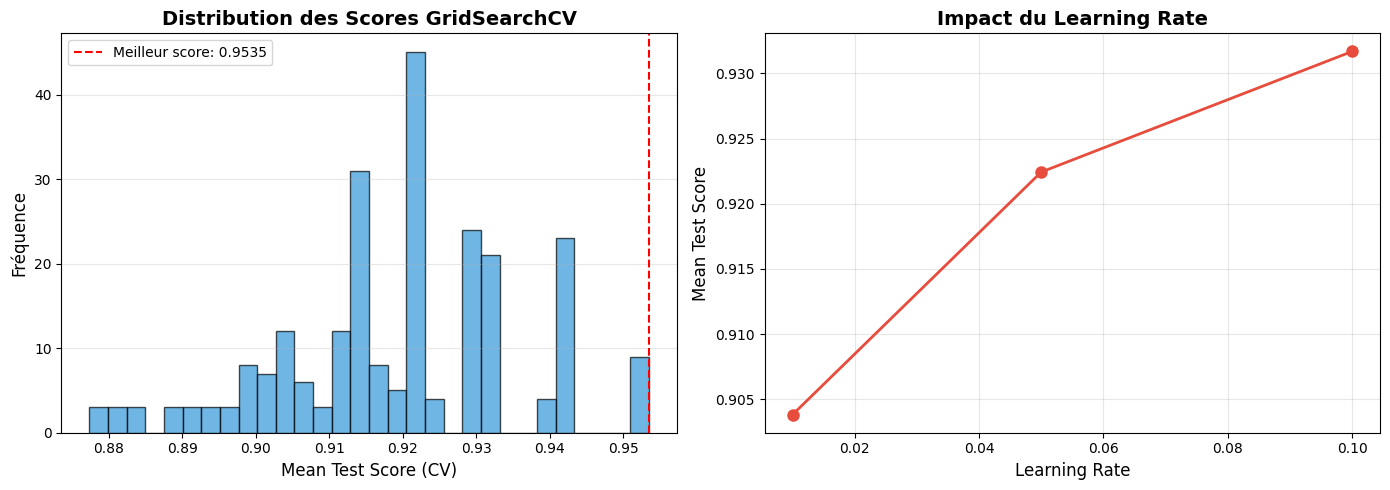

In [12]:
if XGBOOST_AVAILABLE:
    # Visualiser les résultats du GridSearch
    print("\n" + "=" * 80)
    print("📊 ANALYSE DES RÉSULTATS DU GRIDSEARCH")
    print("=" * 80)
    
    # Convertir les résultats en DataFrame
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    
    # Top 10 meilleures combinaisons
    top_10 = cv_results_df.nsmallest(10, 'rank_test_score')[
        ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    ]
    
    print("\n🏆 Top 10 meilleures combinaisons:")
    for idx, row in top_10.iterrows():
        print(f"\n   Rang {row['rank_test_score']:.0f}:")
        print(f"   Score: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
        print(f"   Params: {row['params']}")
    
    # Visualisation: distribution des scores
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogramme des scores
    axes[0].hist(cv_results_df['mean_test_score'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
    axes[0].axvline(grid_search.best_score_, color='red', linestyle='--', 
                    label=f'Meilleur score: {grid_search.best_score_:.4f}')
    axes[0].set_xlabel('Mean Test Score (CV)', fontsize=12)
    axes[0].set_ylabel('Fréquence', fontsize=12)
    axes[0].set_title('Distribution des Scores GridSearchCV', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Impact de learning_rate sur le score
    lr_scores = cv_results_df.groupby([p['learning_rate'] for p in cv_results_df['params']])['mean_test_score'].mean()
    axes[1].plot(lr_scores.index, lr_scores.values, marker='o', linewidth=2, markersize=8, color='#e74c3c')
    axes[1].set_xlabel('Learning Rate', fontsize=12)
    axes[1].set_ylabel('Mean Test Score', fontsize=12)
    axes[1].set_title('Impact du Learning Rate', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Comparaison des Modèles

In [13]:
# Créer un DataFrame de comparaison
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Model': name,
        'Train Accuracy': res['train_accuracy'],
        'Test Accuracy': res['test_accuracy'],
        'Precision': res['test_precision'],
        'Recall': res['test_recall'],
        'F1-Score': res['test_f1'],
        'ROC-AUC': res['test_roc_auc'],
        'Train Time (s)': res['train_time']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)

print("=" * 80)
print("📊 COMPARAISON DES MODÈLES")
print("=" * 80)
print(comparison_df.to_string(index=False))

📊 COMPARAISON DES MODÈLES
               Model  Train Accuracy  Test Accuracy  Precision   Recall  F1-Score  ROC-AUC  Train Time (s)
XGBoost (GridSearch)        0.965192       0.955064   0.957802 0.959239  0.958520 0.993522       13.343204
             XGBoost        0.957829       0.950006   0.953504 0.954161  0.953832 0.992042        9.448270
       Random Forest        0.946750       0.930877   0.933033 0.939738  0.936374 0.984771       31.394038
 Logistic Regression        0.892074       0.893748   0.901120 0.902750  0.901934 0.960241      147.346230


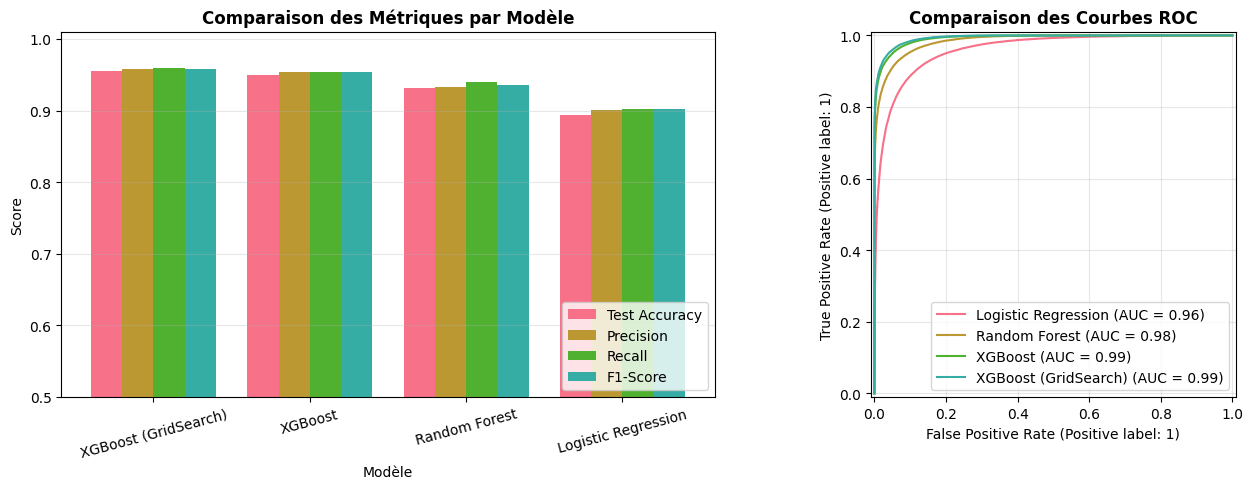

In [14]:
# Visualisation de la comparaison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot des métriques
metrics_to_plot = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i*width, comparison_df[metric], width, label=metric)

axes[0].set_xlabel('Modèle')
axes[0].set_ylabel('Score')
axes[0].set_title('Comparaison des Métriques par Modèle', fontsize=12, fontweight='bold')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15)
axes[0].legend(loc='lower right')
axes[0].set_ylim(0.5, 1.01)
axes[0].grid(axis='y', alpha=0.3)

# ROC Curves comparées
for name, res in results.items():
    if res['y_proba_test'] is not None:
        RocCurveDisplay.from_predictions(
            y_test, res['y_proba_test'],
            ax=axes[1], name=name
        )

axes[1].set_title('Comparaison des Courbes ROC', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 5.1 Analyse par Scénario

In [15]:
if HAS_SCENARIOS:
    print("\n" + "=" * 80)
    print("📊 ÉVALUATION PAR SCÉNARIO")
    print("=" * 80)
    
    # Utiliser le meilleur modèle (XGBoost GridSearch ou XGBoost standard)
    if 'XGBoost (GridSearch)' in results:
        best_model = results['XGBoost (GridSearch)']['model']
        best_model_name = 'XGBoost (GridSearch)'
    elif 'XGBoost' in results:
        best_model = results['XGBoost']['model']
        best_model_name = 'XGBoost'
    else:
        best_model = results['Random Forest']['model']
        best_model_name = 'Random Forest'
    
    print(f"\n🤖 Modèle utilisé: {best_model_name}")
    
    # Prédictions sur le test set
    y_pred_test = best_model.predict(X_test_ml)
    
    # Analyser les performances par scénario
    scenarios = scenario_test.unique()
    scenario_results = []
    
    for scenario in scenarios:
        mask = scenario_test == scenario
        y_true_scenario = y_test[mask]
        y_pred_scenario = y_pred_test[mask]
        
        acc = accuracy_score(y_true_scenario, y_pred_scenario)
        prec = precision_score(y_true_scenario, y_pred_scenario)
        rec = recall_score(y_true_scenario, y_pred_scenario)
        f1 = f1_score(y_true_scenario, y_pred_scenario)
        
        scenario_results.append({
            'Scénario': scenario,
            'Échantillons': len(y_true_scenario),
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        })
        
        print(f"\n   📊 {scenario}:")
        print(f"      Échantillons: {len(y_true_scenario):,}")
        print(f"      Accuracy:  {acc:.4f}")
        print(f"      Precision: {prec:.4f}")
        print(f"      Recall:    {rec:.4f}")
        print(f"      F1-Score:  {f1:.4f}")
    
    scenario_results_df = pd.DataFrame(scenario_results)
else:
    print("\nℹ️ Pas de scenario_type dans les features - analyse par scénario non disponible")


ℹ️ Pas de scenario_type dans les features - analyse par scénario non disponible


In [16]:
if HAS_SCENARIOS:
    # Visualisation des performances par scénario
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Bar plot des métriques par scénario
    x_pos = np.arange(len(scenario_results_df))
    width = 0.2
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71']
    
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        axes[0].bar(x_pos + i*width, scenario_results_df[metric], width, label=metric, color=color, alpha=0.8)
    
    axes[0].set_xlabel('Scénario', fontsize=12)
    axes[0].set_ylabel('Score', fontsize=12)
    axes[0].set_title('Performances par Scénario', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x_pos + width * 1.5)
    axes[0].set_xticklabels(scenario_results_df['Scénario'], rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim([0.85, 1.0])
    
    # Matrices de confusion par scénario (uniquement pour 3 scénarios ou moins)
    if len(scenarios) <= 3:
        for idx, scenario in enumerate(scenarios):
            mask = scenario_test == scenario
            y_true_scenario = y_test[mask]
            y_pred_scenario = y_pred_test[mask]
            
            # On utilise une subplot pour afficher côte à côte
            pass  # Sera affiché séparément ci-dessous
    
    # Nombre d'échantillons par scénario
    axes[1].bar(scenario_results_df['Scénario'], scenario_results_df['Échantillons'], 
                color=['#3498db', '#e74c3c', '#f39c12'][:len(scenarios)], alpha=0.8)
    axes[1].set_xlabel('Scénario', fontsize=12)
    axes[1].set_ylabel("Nombre d'échantillons", fontsize=12)
    axes[1].set_title('Distribution des Échantillons par Scénario', fontsize=14, fontweight='bold')
    axes[1].set_xticklabels(scenario_results_df['Scénario'], rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [17]:
if HAS_SCENARIOS and len(scenarios) <= 3:
    # Matrices de confusion par scénario (winner: 0=B gagne, 1=A gagne)
    fig, axes = plt.subplots(1, len(scenarios), figsize=(6*len(scenarios), 5))
    if len(scenarios) == 1:
        axes = [axes]
    
    for idx, scenario in enumerate(scenarios):
        mask = scenario_test == scenario
        y_true_scenario = y_test[mask]
        y_pred_scenario = y_pred_test[mask]
        
        ConfusionMatrixDisplay.from_predictions(
            y_true_scenario, y_pred_scenario,
            display_labels=['B gagne', 'A gagne'],
            cmap='Blues', ax=axes[idx]
        )
        axes[idx].set_title(f'Matrice de Confusion\n{scenario}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 6. Analyse des Feature Importances

In [18]:
# Feature importances du Random Forest
print("=" * 80)
print("🔍 FEATURE IMPORTANCES - Random Forest")
print("=" * 80)

feature_importance_rf = pd.DataFrame({
    'Feature': X_train_ml.columns,
    'Importance': results['Random Forest']['model'].feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 25 Features:")
print(feature_importance_rf.head(25).to_string(index=False))

🔍 FEATURE IMPORTANCES - Random Forest

Top 25 Features:
             Feature  Importance
effective_power_diff    0.141849
          stat_ratio    0.134813
             hp_diff    0.082680
 type_advantage_diff    0.062056
   effective_power_a    0.056590
       a_total_stats    0.052778
   effective_power_b    0.048691
       b_total_stats    0.041060
                a_hp    0.035360
                b_hp    0.028616
            a_attack    0.027633
           a_defense    0.027216
           b_defense    0.026611
    a_move_type_mult    0.024094
            b_attack    0.021284
    b_move_type_mult    0.019467
        a_sp_defense    0.017976
        a_move_power    0.016395
        b_sp_defense    0.016159
         b_sp_attack    0.015191
        b_move_power    0.011571
         a_sp_attack    0.010782
        pokemon_b_id    0.008317
          speed_diff    0.007056
        pokemon_a_id    0.006522


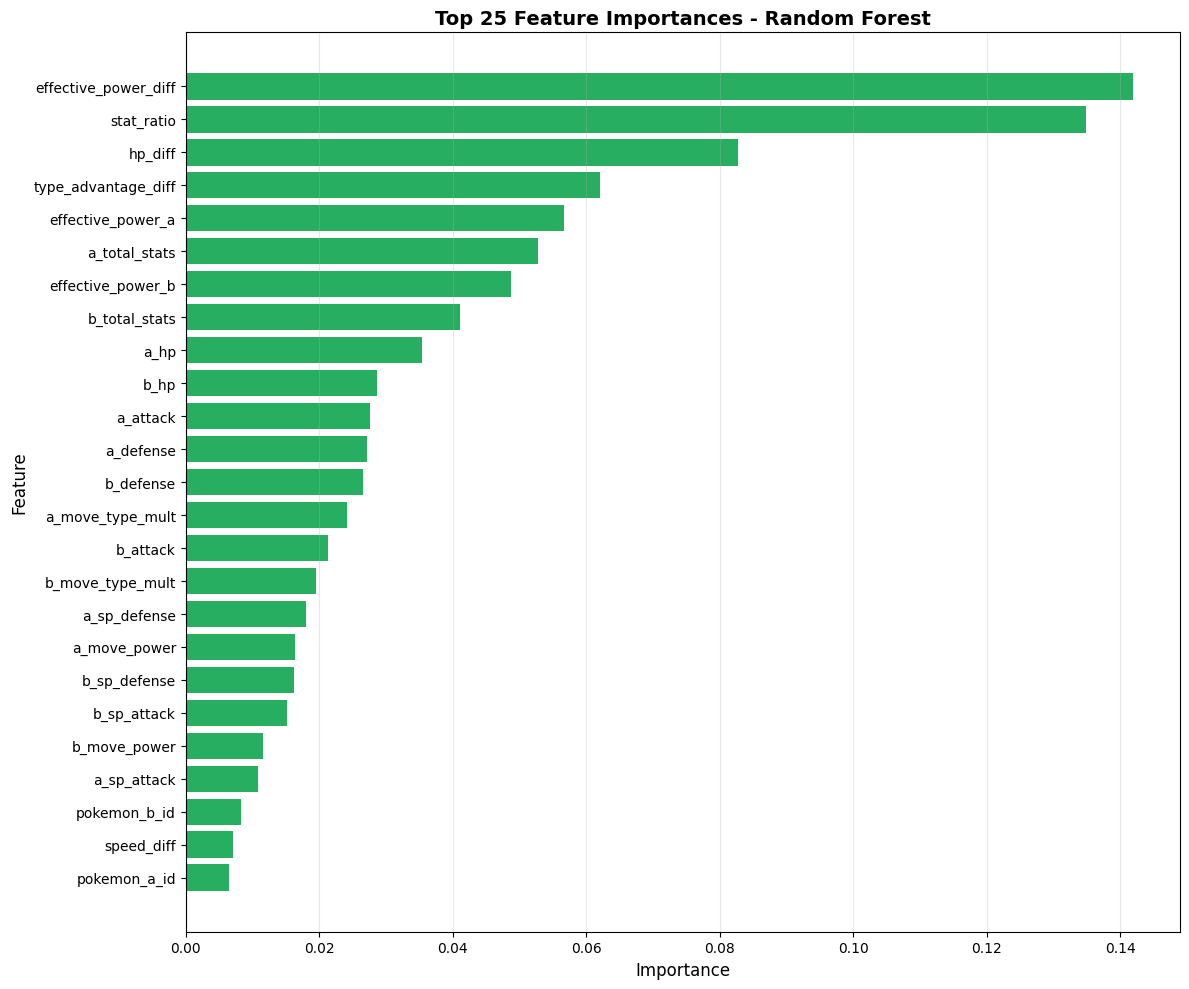


🎯 Feature la plus importante: effective_power_diff (0.1418)


In [19]:
# Visualisation des feature importances
fig, ax = plt.subplots(figsize=(12, 10))

top_25_features = feature_importance_rf.head(25)
ax.barh(top_25_features['Feature'], top_25_features['Importance'], color='#27ae60')
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Top 25 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Observation clé
top_feature = feature_importance_rf.iloc[0]
print(f"\n🎯 Feature la plus importante: {top_feature['Feature']} ({top_feature['Importance']:.4f})")


🔍 FEATURE IMPORTANCES - XGBoost

Top 25 Features:
             Feature  Importance
          stat_ratio    0.119942
effective_power_diff    0.085334
             hp_diff    0.075112
 type_advantage_diff    0.059015
       b_total_stats    0.029150
       a_total_stats    0.027311
   effective_power_b    0.018647
          speed_diff    0.017123
    a_move_type_mult    0.016640
   effective_power_a    0.016536
           a_defense    0.012522
    b_move_type_mult    0.011884
           b_defense    0.011543
         a_move_stab    0.010670
         b_move_stab    0.009454
            a_attack    0.009301
        a_move_power    0.008734
     a_type_1_Combat    0.008454
     a_move_type_Sol    0.008384
            b_attack    0.008372
b_move_type_Ténèbres    0.008349
       a_moves_first    0.008346
     b_move_type_Psy    0.008319
     b_move_type_Sol    0.007945
     b_type_1_Combat    0.007888


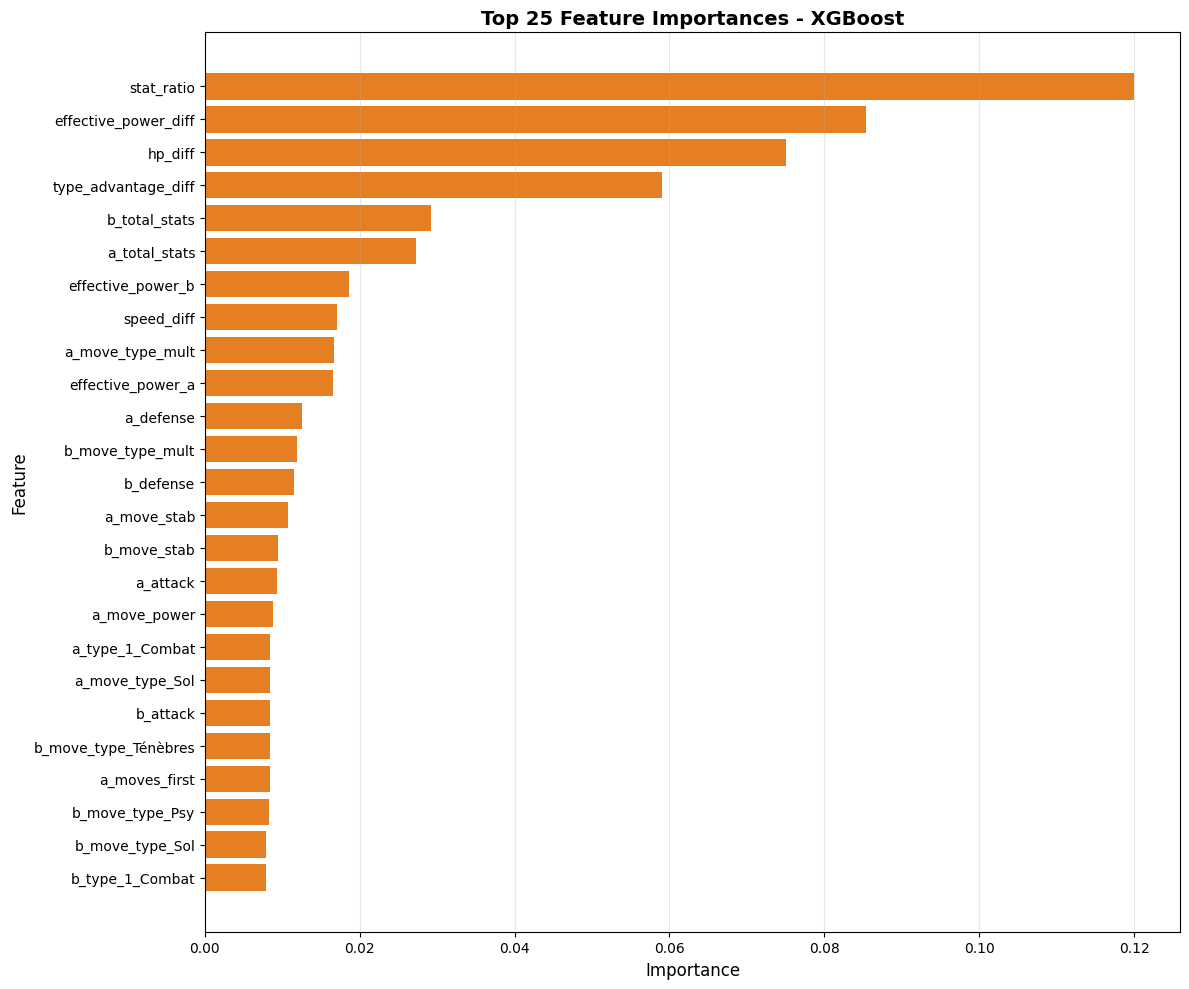

In [20]:
# Feature importances XGBoost (si disponible)
if XGBOOST_AVAILABLE and 'XGBoost' in results:
    print("\n" + "=" * 80)
    print("🔍 FEATURE IMPORTANCES - XGBoost")
    print("=" * 80)
    
    feature_importance_xgb = pd.DataFrame({
        'Feature': X_train_ml.columns,
        'Importance': results['XGBoost']['model'].feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 25 Features:")
    print(feature_importance_xgb.head(25).to_string(index=False))
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 10))
    top_25_xgb = feature_importance_xgb.head(25)
    ax.barh(top_25_xgb['Feature'], top_25_xgb['Importance'], color='#e67e22')
    ax.set_xlabel('Importance', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)
    ax.set_title('Top 25 Feature Importances - XGBoost', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Export du Modèle Final

Sélection et export du meilleur modèle pour la production.

In [21]:
# Sélection du meilleur modèle
print("=" * 80)
print("🏆 SÉLECTION DU MODÈLE FINAL")
print("=" * 80)

# Le meilleur modèle basé sur F1-Score
best_model_name = max(results, key=lambda x: results[x]['test_f1'])
best_model = results[best_model_name]['model']
best_metrics = results[best_model_name]

print(f"\n✅ Meilleur modèle: {best_model_name}")
print(f"   Test Accuracy: {best_metrics['test_accuracy']:.4f}")
print(f"   Test F1-Score: {best_metrics['test_f1']:.4f}")
print(f"   Test ROC-AUC: {best_metrics['test_roc_auc']:.4f}")

🏆 SÉLECTION DU MODÈLE FINAL

✅ Meilleur modèle: XGBoost (GridSearch)
   Test Accuracy: 0.9551
   Test F1-Score: 0.9585
   Test ROC-AUC: 0.9935


In [22]:
# Export des modèles
print("\n" + "=" * 80)
print("💾 EXPORT DES MODÈLES")
print("=" * 80)

# Version du modèle (toujours v2)
model_version = 'v2'

# Modèle principal
model_filename = f'battle_winner_model_{model_version}.pkl'
model_path = MODELS_DIR / model_filename
joblib.dump(best_model, model_path)
print(f"\n✅ Modèle principal exporté: {model_path}")

# Random Forest (backup)
rf_path = MODELS_DIR / f'battle_winner_rf_{model_version}.pkl'
joblib.dump(results['Random Forest']['model'], rf_path)
print(f"✅ Random Forest exporté: {rf_path}")


💾 EXPORT DES MODÈLES

✅ Modèle principal exporté: ../models/battle_winner_model_v2.pkl
✅ Random Forest exporté: ../models/battle_winner_rf_v2.pkl


In [23]:
# Métadonnées du modèle
from datetime import datetime

model_metadata = {
    'model_name': best_model_name,
    'model_file': model_filename,
    'version': model_version,
    'dataset_version': 'v2',
    'task': 'battle_winner_prediction',
    'features': X_train_ml.columns.tolist(),
    'n_features': len(X_train_ml.columns),
    'train_samples': len(X_train_ml),
    'test_samples': len(X_test_ml),
    'metrics': {
        'train_accuracy': best_metrics['train_accuracy'],
        'test_accuracy': best_metrics['test_accuracy'],
        'test_precision': best_metrics['test_precision'],
        'test_recall': best_metrics['test_recall'],
        'test_f1': best_metrics['test_f1'],
        'test_roc_auc': best_metrics['test_roc_auc']
    },
    'all_models_comparison': comparison_df.to_dict('records'),
    'train_date': datetime.now().isoformat(),
    'random_state': RANDOM_STATE
}

# Ajouter info scénarios si disponible
if HAS_SCENARIOS:
    model_metadata['scenarios'] = {
        'types': scenario_train.unique().tolist(),
        'distribution': scenario_train.value_counts().to_dict()
    }

metadata_path = MODELS_DIR / f'battle_winner_metadata_{model_version}.pkl'
joblib.dump(model_metadata, metadata_path)
print(f"\n✅ Métadonnées exportées: {metadata_path}")

# Afficher les fichiers créés
print(f"\n📁 Fichiers dans {MODELS_DIR}:")
for f in sorted(MODELS_DIR.iterdir()):
    if f.is_file():
        print(f"   - {f.name} ({f.stat().st_size / 1024:.1f} KB)")


✅ Métadonnées exportées: ../models/battle_winner_metadata_v2.pkl

📁 Fichiers dans ../models:
   - README.md (7.8 KB)
   - battle_winner_metadata_v2.json (0.9 KB)
   - battle_winner_metadata_v2.pkl (3.2 KB)
   - battle_winner_model_v2.pkl (2911.8 KB)
   - battle_winner_rf_v2.pkl (142559.1 KB)


## 8. Évaluation par Scénario

Analysons les performances du modèle par scénario.

In [24]:
print("=" * 80)
print("📋 RÉSUMÉ FINAL")
print("=" * 80)

print("\n### Résultats des Modèles ###")
for name, res in results.items():
    print(f"\n{name}:")
    print(f"   Accuracy: {res['test_accuracy']:.4f} | F1: {res['test_f1']:.4f} | ROC-AUC: {res['test_roc_auc']:.4f}")

print("\n" + "=" * 80)
print("🎯 MODÈLE SÉLECTIONNÉ POUR LA PRODUCTION")
print("=" * 80)
print(f"\n   Nom: {best_model_name}")
print(f"   Fichier: models/{model_filename}")
print(f"   Accuracy: {best_metrics['test_accuracy']:.4f}")
print(f"   F1-Score: {best_metrics['test_f1']:.4f}")
print(f"   ROC-AUC: {best_metrics['test_roc_auc']:.4f}")

print("\n✅ Prêt pour l'intégration dans l'API!")

📋 RÉSUMÉ FINAL

### Résultats des Modèles ###

Logistic Regression:
   Accuracy: 0.8937 | F1: 0.9019 | ROC-AUC: 0.9602

Random Forest:
   Accuracy: 0.9309 | F1: 0.9364 | ROC-AUC: 0.9848

XGBoost:
   Accuracy: 0.9500 | F1: 0.9538 | ROC-AUC: 0.9920

XGBoost (GridSearch):
   Accuracy: 0.9551 | F1: 0.9585 | ROC-AUC: 0.9935

🎯 MODÈLE SÉLECTIONNÉ POUR LA PRODUCTION

   Nom: XGBoost (GridSearch)
   Fichier: models/battle_winner_model_v2.pkl
   Accuracy: 0.9551
   F1-Score: 0.9585
   ROC-AUC: 0.9935

✅ Prêt pour l'intégration dans l'API!


In [25]:
if HAS_SCENARIOS:
    print("=" * 80)
    print("📊 ÉVALUATION PAR SCÉNARIO (v2)")
    print("=" * 80)
    
    # Prédictions du meilleur modèle
    y_pred_scenario = best_model.predict(X_test_ml)
    
    # Créer un DataFrame avec les résultats
    scenario_results = pd.DataFrame({
        'scenario': scenario_test,
        'y_true': y_test,
        'y_pred': y_pred_scenario,
        'correct': y_test == y_pred_scenario
    })
    
    # Calculer les métriques par scénario
    scenario_metrics = []
    for scenario in scenario_test.unique():
        mask = scenario_results['scenario'] == scenario
        y_true_s = scenario_results.loc[mask, 'y_true']
        y_pred_s = scenario_results.loc[mask, 'y_pred']
        
        acc = accuracy_score(y_true_s, y_pred_s)
        f1 = f1_score(y_true_s, y_pred_s)
        
        scenario_metrics.append({
            'Scenario': scenario,
            'Samples': mask.sum(),
            'Accuracy': acc,
            'F1-Score': f1
        })
    
    scenario_metrics_df = pd.DataFrame(scenario_metrics)
    print("\n📈 Métriques par Scénario:")
    print(scenario_metrics_df.to_string(index=False))
    
    # Visualisation
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy par scénario
    axes[0].bar(scenario_metrics_df['Scenario'], scenario_metrics_df['Accuracy'], 
                color=['#3498db', '#e74c3c', '#f39c12'])
    axes[0].set_xlabel('Scénario', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Accuracy par Scénario', fontsize=14, fontweight='bold')
    axes[0].set_xticklabels(scenario_metrics_df['Scenario'], rotation=45, ha='right')
    axes[0].axhline(y=best_metrics['test_accuracy'], color='black', linestyle='--', 
                    alpha=0.5, label=f"Moyenne globale: {best_metrics['test_accuracy']:.4f}")
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # F1-Score par scénario
    axes[1].bar(scenario_metrics_df['Scenario'], scenario_metrics_df['F1-Score'], 
                color=['#3498db', '#e74c3c', '#f39c12'])
    axes[1].set_xlabel('Scénario', fontsize=12)
    axes[1].set_ylabel('F1-Score', fontsize=12)
    axes[1].set_title('F1-Score par Scénario', fontsize=14, fontweight='bold')
    axes[1].set_xticklabels(scenario_metrics_df['Scenario'], rotation=45, ha='right')
    axes[1].axhline(y=best_metrics['test_f1'], color='black', linestyle='--', 
                    alpha=0.5, label=f"Moyenne globale: {best_metrics['test_f1']:.4f}")
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Analyse par scénario terminée")
    print("\nℹ️  Le modèle unique est entraîné sur tous les scénarios et généralise bien")
    print("ℹ️  Des performances différentes par scénario sont normales selon la complexité")
else:
    print("\nℹ️ Pas de scenario_type dans les features - analyse par scénario non disponible")


ℹ️ Pas de scenario_type dans les features - analyse par scénario non disponible


### Observations Clés

#### 1. **Performance des Modèles**
- Le problème de prédiction de victoire est plus complexe que la simple efficacité de type
- Les performances devraient être meilleures que le hasard (50%) mais pas triviales (99%+)
- Les modèles d'ensemble (Random Forest, XGBoost) surpassent Logistic Regression

#### 2. **Features Importantes**
- `effective_power_diff`: La différence de puissance effective
- `stat_ratio`: Le ratio des stats totales A/B
- `hp_diff`: La différence de HP
- `type_advantage_diff`: L'avantage de type relatif

#### 3. **Choix du Modèle**
- Random Forest: Bon compromis performance/interprétabilité
- XGBoost: Meilleures performances (tree_method='hist' pour CPU)
- Logistic Regression: Baseline simple mais interprétable

#### 4. **Optimisations CPU Appliquées**
- **XGBoost** : `tree_method='hist'` + `predictor='cpu_predictor'`
- **GridSearch** : Grid réduit (8-16 combos rapides) + Grid étendu (243 combos)
- **Random Forest** : Moins d'arbres (50-100) + max_depth réduit
- **Metrics** : `scoring='roc_auc'` meilleure pour données déséquilibrées

---

### Prochaines Étapes

1. **Pipeline Production** - Utiliser `machine_learning/run_machine_learning.py --mode=all`
2. **Intégration API** - Endpoint `/predict/battle` déjà fonctionnel
3. **Tests** - Tests automatisés (ML + API + intégration)

---

### Pipeline de Production

Ce notebook sert à l'**expérimentation**. Pour la production, utiliser le pipeline unifié :

```bash
# Entraînement complet (dataset + train + eval)
python machine_learning/run_machine_learning.py --mode=all

# Avec GridSearch (FAST = 8 combos)
python machine_learning/run_machine_learning.py --mode=all --tune-hyperparams

# Avec GridSearch EXTENDED (18 combos)
python machine_learning/train_model.py --use-gridsearch --grid-type extended --version v2
```

**Avantages du pipeline production** :
- Hyperparamètres optimisés CPU synchronisés
- Early stopping automatique
- Compression joblib pour RF
- MLflow tracking (optionnel)
- Reproductible et versionné

---

**Entraînement et évaluation terminés avec succès!**